In [1]:
from PIL import Image,ImageDraw
import os.path as osp
import math
import json
import os
import torch
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset
from shapely.geometry import Polygon
from functools import partial
from augmentation import generate_roi_mask
from matplotlib import pyplot as plt
from augmentation import *

In [2]:
def xy_to_tuple(v):
    new_v = list(map(tuple,v))
    return new_v
def xy_to_xandy(v):
    x,y=list(map(list,zip(*v)))
    return x,y
def find_min_box_from_polygon(vertices):
    rot_v=np.array(vertices)
    vertices.append(vertices[0])
    x,y=xy_to_xandy(rot_v)
    angle = []
    for i in range(len(y)-1):
        y[i]=-(y[i]-y[i+1])
        x[i]=-(x[i]-x[i+1])
    x.pop()
    y.pop()
    angle= -np.arctan2(np.array(y),np.array(x))
    min_area = None
    target_angle = None
    for ang in angle:
        rotate_mat = np.array([[np.cos(ang),-np.sin(ang)],
                            [np.sin(ang),np.cos(ang)]])
        new_v = rotate_mat@rot_v.T
        poly_area = (np.max(new_v[0])-np.min(new_v[0])) * (np.max(new_v[1])-np.min(new_v[1]) )
        if min_area==None or poly_area<min_area:
            min_area=poly_area
            min_bbox = np.array([[np.min(new_v[0]),np.min(new_v[1])],
                            [np.max(new_v[0]),np.min(new_v[1])],
                            [np.max(new_v[0]),np.max(new_v[1])],
                            [np.min(new_v[0]),np.max(new_v[1])]])
            target_angle = ang
    new_bbox = min_bbox
    reverse_mat = np.array([[np.cos(target_angle),np.sin(target_angle)],
                        [-np.sin(target_angle),np.cos(target_angle)]])
    new_polygon = (reverse_mat)@new_bbox.T
    new_polygon = list(map(tuple,zip(*new_polygon.tolist())))
    return new_polygon

def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels

def find_min_box_from_polygon2(vertices):
    numpy_v = np.array(vertices).T
    min_bbox = np.array([[np.min(numpy_v[0]),np.min(numpy_v[1])],
                            [np.max(numpy_v[0]),np.min(numpy_v[1])],
                            [np.max(numpy_v[0]),np.max(numpy_v[1])],
                            [np.min(numpy_v[0]),np.max(numpy_v[1])]])
    return min_bbox
class SceneTextDataset(Dataset):
    def __init__(self, root_dir,
                 split='train',
                 image_size=2048,
                 crop_size=1024,
                 ignore_tags=[],
                 ignore_under_threshold=10,
                 drop_under_threshold=1,
                 polygon_masking=False,
                 aug_list=[]):
        with open(osp.join(root_dir, 'ufo/{}.json'.format(split)), 'r') as f:
            anno = json.load(f)

        self.anno = anno
        self.image_fnames = sorted(anno['images'].keys())
        self.image_dir = osp.join(root_dir, 'img', split)

        self.image_size, self.crop_size = image_size, crop_size

        self.ignore_tags = ignore_tags

        self.drop_under_threshold = drop_under_threshold
        self.ignore_under_threshold = ignore_under_threshold

        self.aug_list = aug_list
        self.polygon_masking = polygon_masking
    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):
        image_fname = self.image_fnames[idx]
        image_fpath = osp.join(self.image_dir, image_fname)

        vertices, labels = [], []
        masking_vertices = []
        for word_info in self.anno['images'][image_fname]['words'].values():
            word_tags = word_info['tags']

            ignore_sample = any(elem for elem in word_tags if elem in self.ignore_tags)
            num_pts = np.array(word_info['points']).shape[0]

            # skip samples with ignore tag and
            # samples with number of points greater than 4
            if ignore_sample :
                continue
            if num_pts > 4:
                if self.polygon_masking:
                    masking_vertices.append(list(map(tuple,word_info['points'])))
                elif False:
                    #print(find_min_box_from_polygon2(word_info['points']))
                    vertices.append(find_min_box_from_polygon2(word_info['points']).flatten())
                    labels.append(int(not word_info['illegibility']))



                continue
            vertices.append(np.array(word_info['points']).flatten())
            labels.append(int(not word_info['illegibility']))
        vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)

        vertices, labels = filter_vertices(
            vertices,
            labels,
            ignore_under=self.ignore_under_threshold,
            drop_under=self.drop_under_threshold
        )

        image = Image.open(image_fpath)
        if masking_vertices and self.polygon_masking:
            AnotationMasking(image,masking_vertices)
        if self.aug_list:
            image,vertices,labels=process_augmentation(image,vertices,labels,self.aug_list)
        else:
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = np.array(image)
        if isinstance(image,Image.Image):
            image=np.array(image)
        word_bboxes = np.reshape(vertices, (-1, 4, 2))
        roi_mask = generate_roi_mask(image, vertices, labels)

        return image, word_bboxes, roi_mask

{'Resize': functools.partial(<function resize_img at 0x7f1a3d97aee0>, size=2048), 'Rotate': functools.partial(<function rotate_img at 0x7f1a3d97d040>, angle_range=5), 'Crop': functools.partial(<function crop_img at 0x7f1a3d97adc0>, length=1024), 'ColorJitter': ColorJitter(always_apply=False, p=0.5, brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.2, 0.2]), 'Normalize': Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=1), 'Emboss': Emboss(always_apply=False, p=1, alpha=(0.2, 0.5), strength=(0.2, 0.7)), 'AdjustHeight': functools.partial(<function adjust_height at 0x7f1a3d97af70>, ratio=0.3), 'ToNumpy': <function ToNumpy at 0x7f1a3d97d160>, 'OnlyBlack': functools.partial(<function OnlyBlack at 0x7f1a3d97d1f0>, cal_type='Sum', cut_val=300), 'Sharpen': Sharpen(always_apply=False, p=0.5, alpha=(0.2, 0.5), lightness=(0.5, 1.0)), 'CLAHE': CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8,

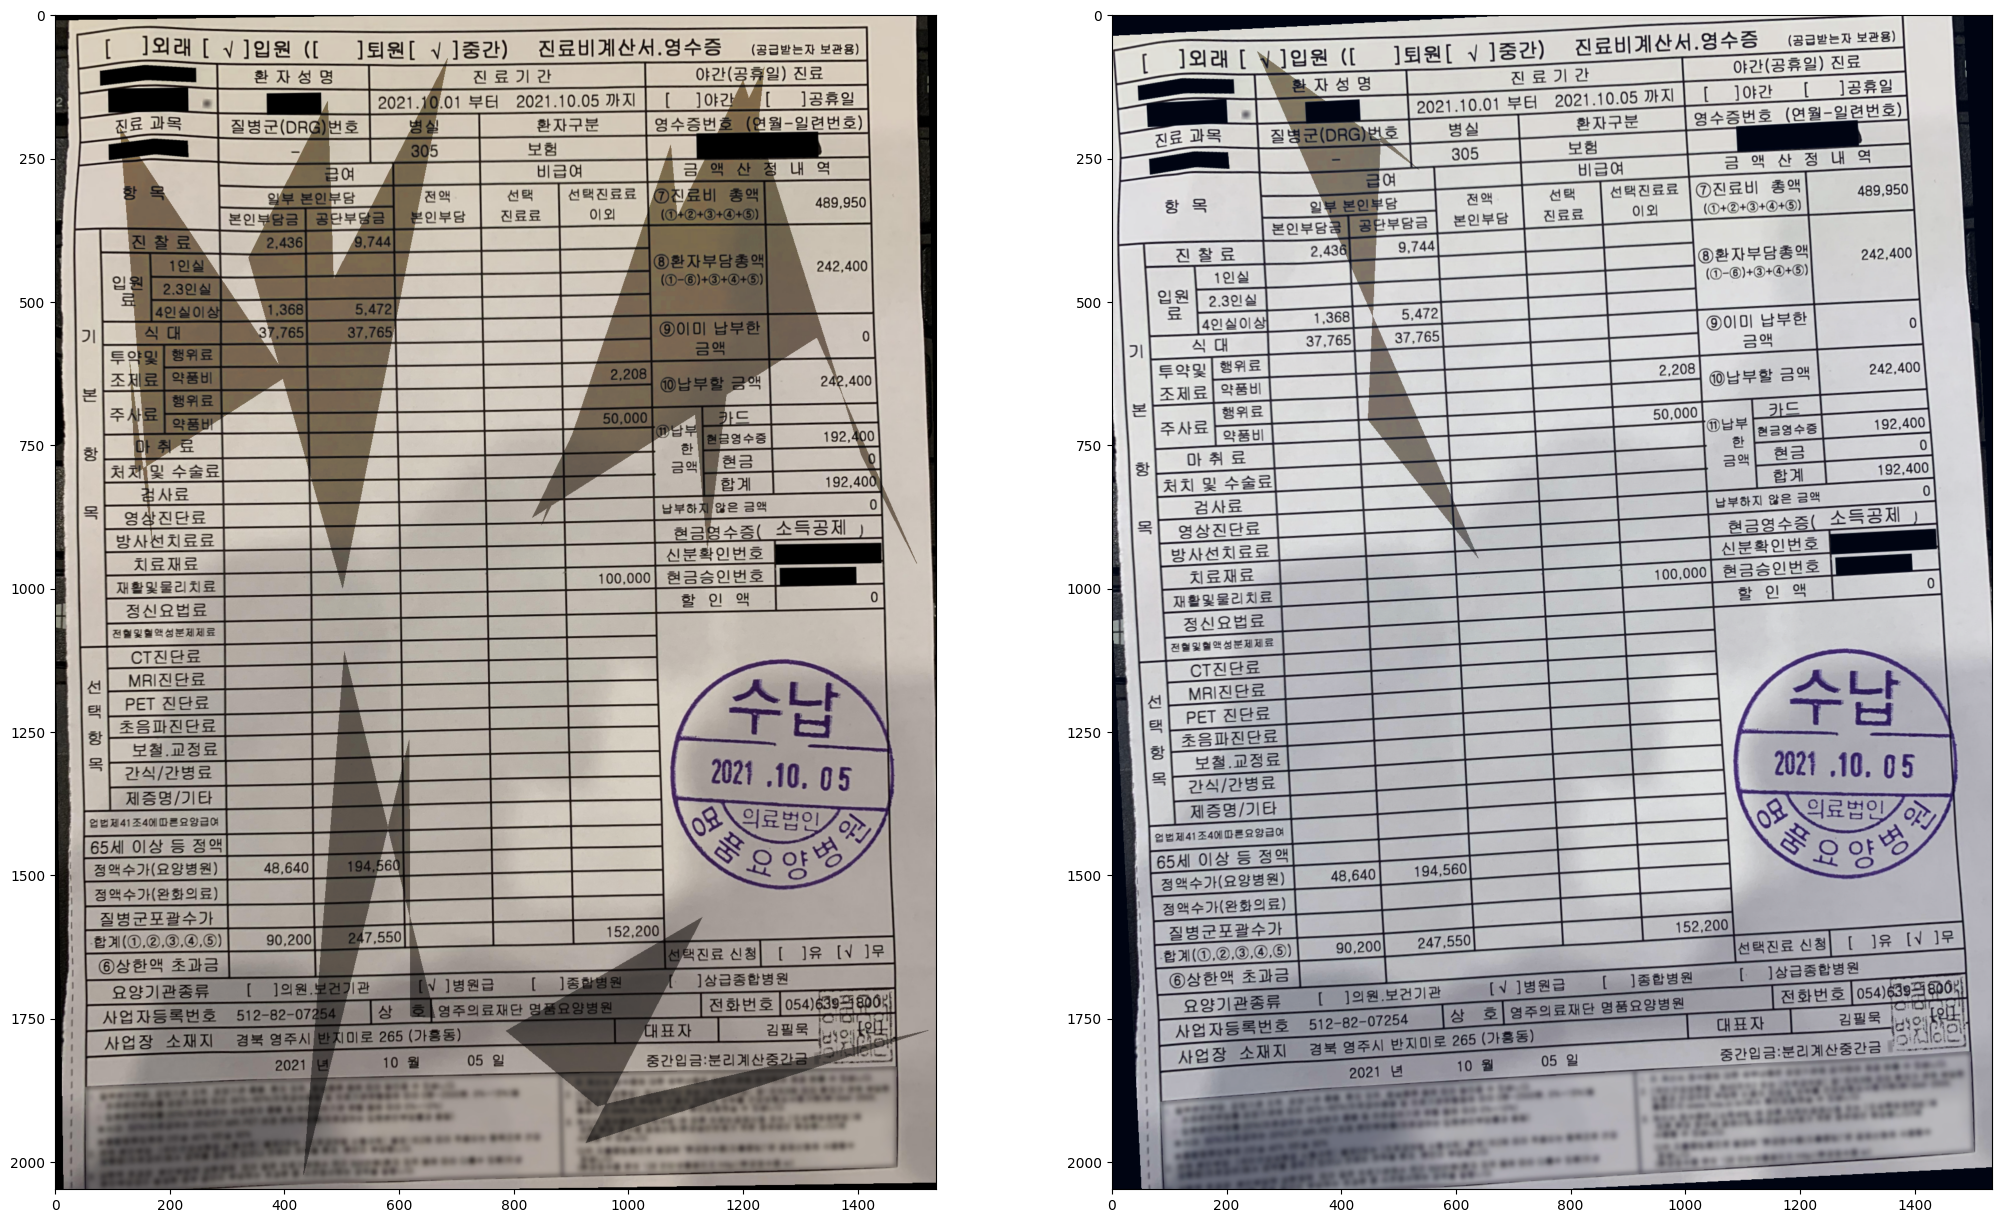

In [16]:
data_dir = os.environ.get('SM_CHANNEL_TRAIN', '../../data/medical')
image_size = 2048
input_size = 1024
ignore_tags = ['masked', 'excluded-region', 'maintable', 'stamp']

test_aug = []
test_aug = ['Resize','Rotate','ToNumpy','MultiRandomShadow','ColorJitter']

dataset = SceneTextDataset(
data_dir,
split='train',
image_size=image_size,
crop_size=input_size,
ignore_tags=ignore_tags,
aug_list=test_aug,
polygon_masking=True
)

idx=93
img,_,_=dataset[idx]
plt.figure(figsize=(25,40))
plt.subplot(1,2,1)
plt.imshow(img)
test_aug = ['Resize','Rotate','ToNumpy','RandomShadow','ColorJitter','Normalize']
dataset.aug_list=test_aug
img2,_,_=dataset[idx]
std=np.max(img2)-np.min(img2)
img2=(img2-np.min(img2))/std
plt.subplot(1,2,2)
plt.imshow(img2)
print(aug_dict)
print(img2.dtype,np.max(img2),np.min(img2))

# aug_list = ['Resize']
# dataset.aug_list=aug_list
# idx=93
# img=dataset[idx]

# plt.figure(figsize=(25,40))
# plt.subplot(1,2,2)
# plt.imshow(img[0])
